In [1]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

import tensorflow as tf

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/home/jupyter/BayesFlow/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Benchmark: Simple Likelihood, Complex Posterior (SLCP)

In [4]:
benchmark_name = 'slcp'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the slcp model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer

In [5]:
amortizer = AmortizedPosteriorLikelihood(
    AmortizedPosterior(
        InvertibleNetwork(
            num_params=5, 
            num_coupling_layers=6, 
            coupling_design='interleaved', 
            permutation='learnable')
    ),
    AmortizedLikelihood(
        InvertibleNetwork(
            num_params=8, 
            num_coupling_layers=4, 
            permutation='learnable')
    )
)

In [6]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=5e-4,
    generative_model=benchmark.generative_model,
    configurator=benchmark.configurator,
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1
)

INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training

Uncomment for training. Uncomment for training. Wall time with GPU: approx. 15min 17s

In [7]:
EPOCHS = 50
SIMULATION_BUDGET = 10000
BATCH_SIZE = 32
N_VAL = 300

train_data = trainer.generative_model(SIMULATION_BUDGET)

In [8]:
%%time
h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

INFO:root:Generated 300 simulations for validation.


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1, Post.Loss: 8.509, Lik.Loss: -4.639


Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Post.Loss: 8.184, Lik.Loss: -7.098


Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Post.Loss: 7.891, Lik.Loss: -9.744


Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Post.Loss: 7.625, Lik.Loss: -11.392


Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Post.Loss: 7.442, Lik.Loss: -12.036


Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Post.Loss: 7.322, Lik.Loss: -12.530


Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Post.Loss: 7.146, Lik.Loss: -12.858


Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Post.Loss: 7.025, Lik.Loss: -13.209


Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Post.Loss: 6.876, Lik.Loss: -13.243


Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Post.Loss: 6.906, Lik.Loss: -13.530


Training epoch 11:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Post.Loss: 6.756, Lik.Loss: -13.558


Training epoch 12:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Post.Loss: 6.599, Lik.Loss: -13.811


Training epoch 13:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Post.Loss: 6.520, Lik.Loss: -13.846


Training epoch 14:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Post.Loss: 6.409, Lik.Loss: -13.779


Training epoch 15:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Post.Loss: 6.224, Lik.Loss: -13.928


Training epoch 16:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Post.Loss: 6.168, Lik.Loss: -14.020


Training epoch 17:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Post.Loss: 6.072, Lik.Loss: -14.142


Training epoch 18:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Post.Loss: 6.097, Lik.Loss: -14.154


Training epoch 19:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Post.Loss: 5.925, Lik.Loss: -14.199


Training epoch 20:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Post.Loss: 5.898, Lik.Loss: -14.226


Training epoch 21:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Post.Loss: 5.731, Lik.Loss: -14.404


Training epoch 22:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Post.Loss: 5.758, Lik.Loss: -14.306


Training epoch 23:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Post.Loss: 5.720, Lik.Loss: -14.357


Training epoch 24:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Post.Loss: 5.599, Lik.Loss: -14.426


Training epoch 25:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Post.Loss: 5.658, Lik.Loss: -14.490


Training epoch 26:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Post.Loss: 5.553, Lik.Loss: -14.502


Training epoch 27:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Post.Loss: 5.583, Lik.Loss: -14.567


Training epoch 28:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Post.Loss: 5.486, Lik.Loss: -14.639


Training epoch 29:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Post.Loss: 5.469, Lik.Loss: -14.624


Training epoch 30:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Post.Loss: 5.468, Lik.Loss: -14.681


Training epoch 31:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Post.Loss: 5.396, Lik.Loss: -14.629


Training epoch 32:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Post.Loss: 5.434, Lik.Loss: -14.762


Training epoch 33:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Post.Loss: 5.367, Lik.Loss: -14.764


Training epoch 34:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Post.Loss: 5.332, Lik.Loss: -14.701


Training epoch 35:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Post.Loss: 5.320, Lik.Loss: -14.768


Training epoch 36:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Post.Loss: 5.317, Lik.Loss: -14.855


Training epoch 37:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Post.Loss: 5.336, Lik.Loss: -14.891


Training epoch 38:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Post.Loss: 5.283, Lik.Loss: -14.867


Training epoch 39:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Post.Loss: 5.268, Lik.Loss: -14.887


Training epoch 40:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Post.Loss: 5.253, Lik.Loss: -14.928


Training epoch 41:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Post.Loss: 5.231, Lik.Loss: -14.914


Training epoch 42:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Post.Loss: 5.259, Lik.Loss: -14.926


Training epoch 43:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Post.Loss: 5.239, Lik.Loss: -14.968


Training epoch 44:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Post.Loss: 5.224, Lik.Loss: -14.956


Training epoch 45:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Post.Loss: 5.248, Lik.Loss: -14.951


Training epoch 46:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Post.Loss: 5.234, Lik.Loss: -14.973


Training epoch 47:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Post.Loss: 5.238, Lik.Loss: -14.981


Training epoch 48:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Post.Loss: 5.232, Lik.Loss: -14.976


Training epoch 49:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Post.Loss: 5.234, Lik.Loss: -14.979


Training epoch 50:   0%|          | 0/313 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Post.Loss: 5.235, Lik.Loss: -14.978


CPU times: user 19min 36s, sys: 2min 37s, total: 22min 13s
Wall time: 15min 17s


# Validation

## Loss Trajectories

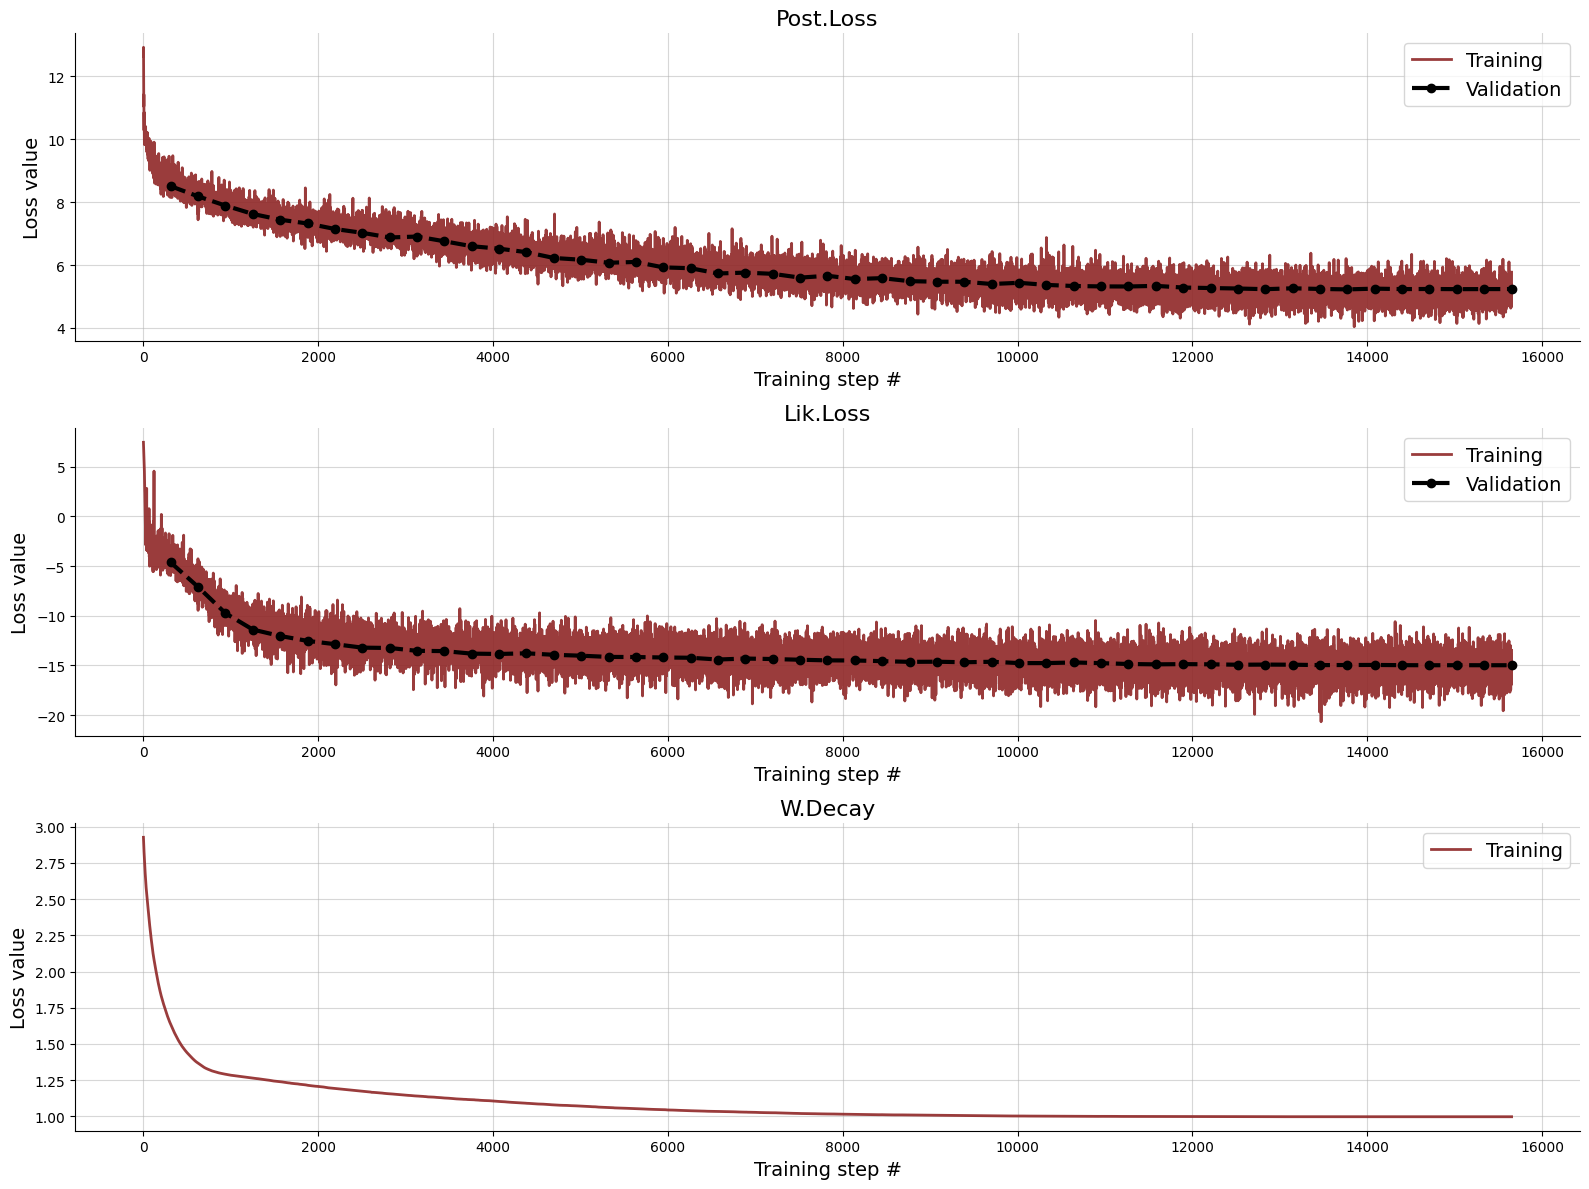

In [9]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

In [10]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [11]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'direct_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

## Individual ECDF Calibration Plots

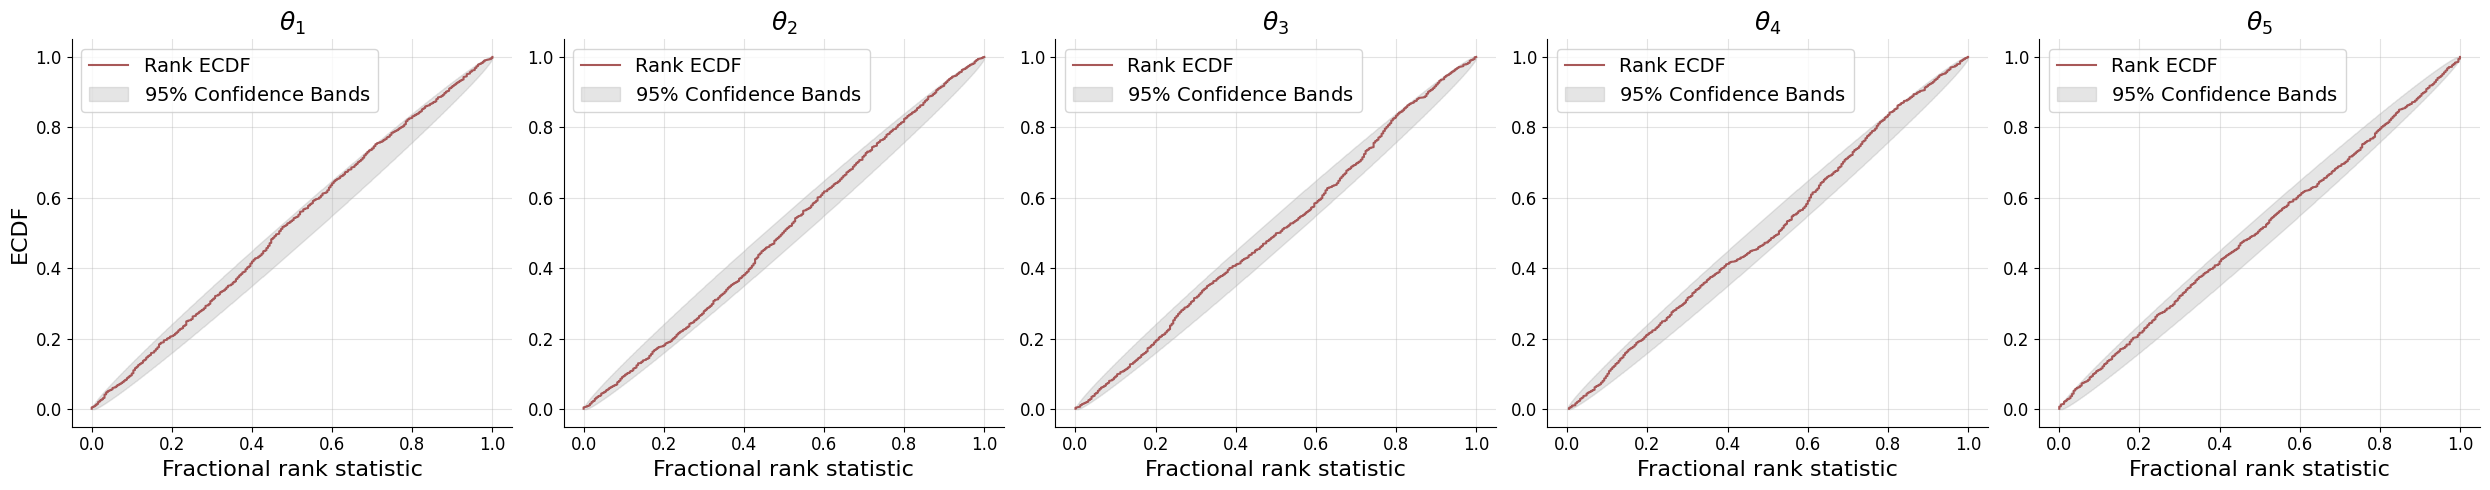

In [12]:
f = plot_sbc_ecdf(post_samples_s, prior_samples, ecdf_bands_kwargs=dict(confidence=0.95))

## Recovery
Observe the hints for bimodality, as per construction.

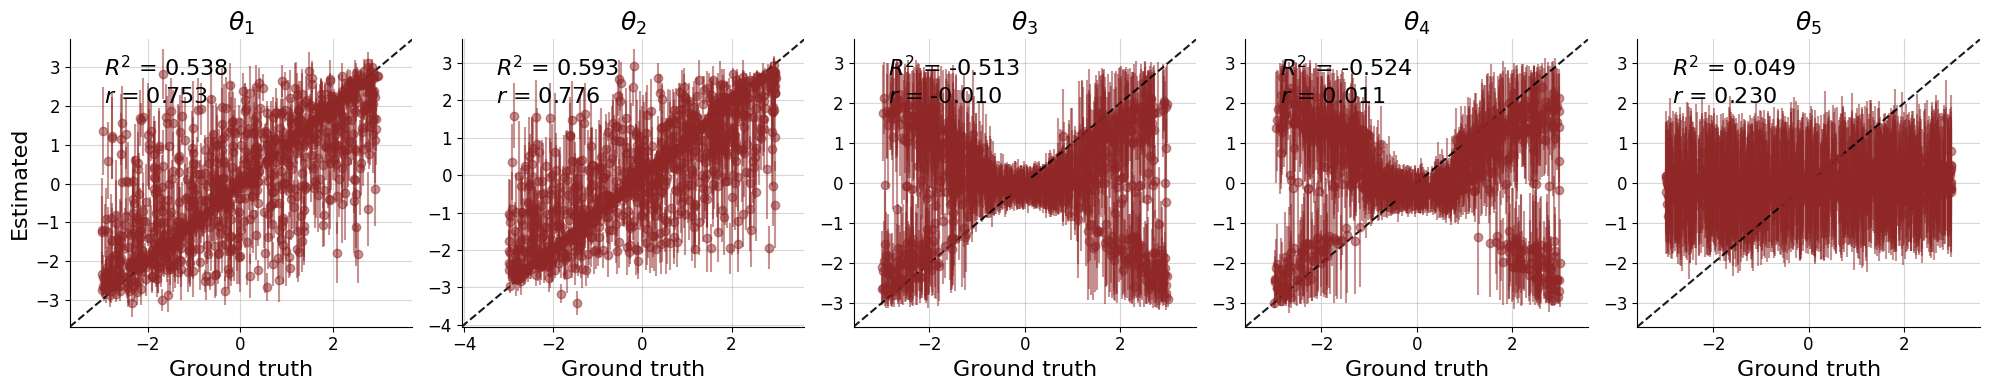

In [13]:
f = plot_recovery(post_samples, prior_samples)

## Example Bivariate Posteriors

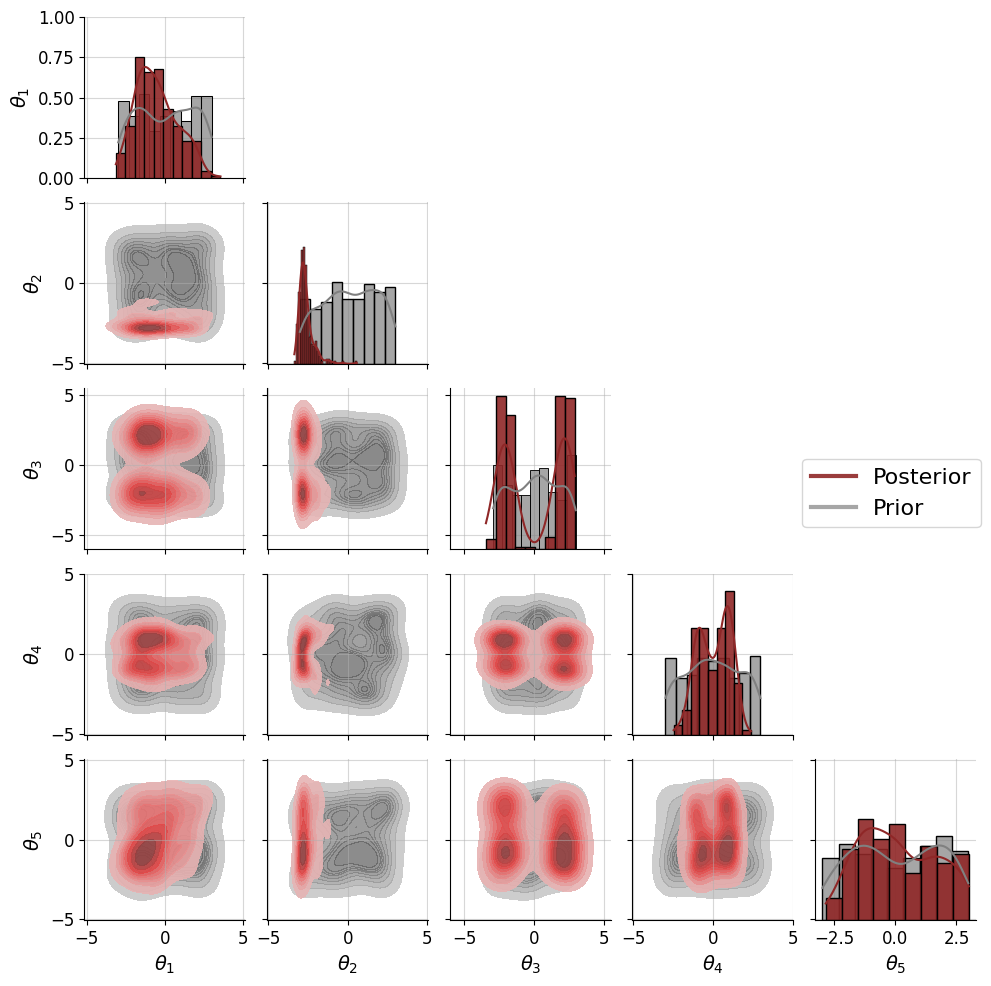

In [14]:
f = plot_posterior_2d(post_samples[0], prior=benchmark.generative_model.prior, height=2)

# Appendix Plots

In [15]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

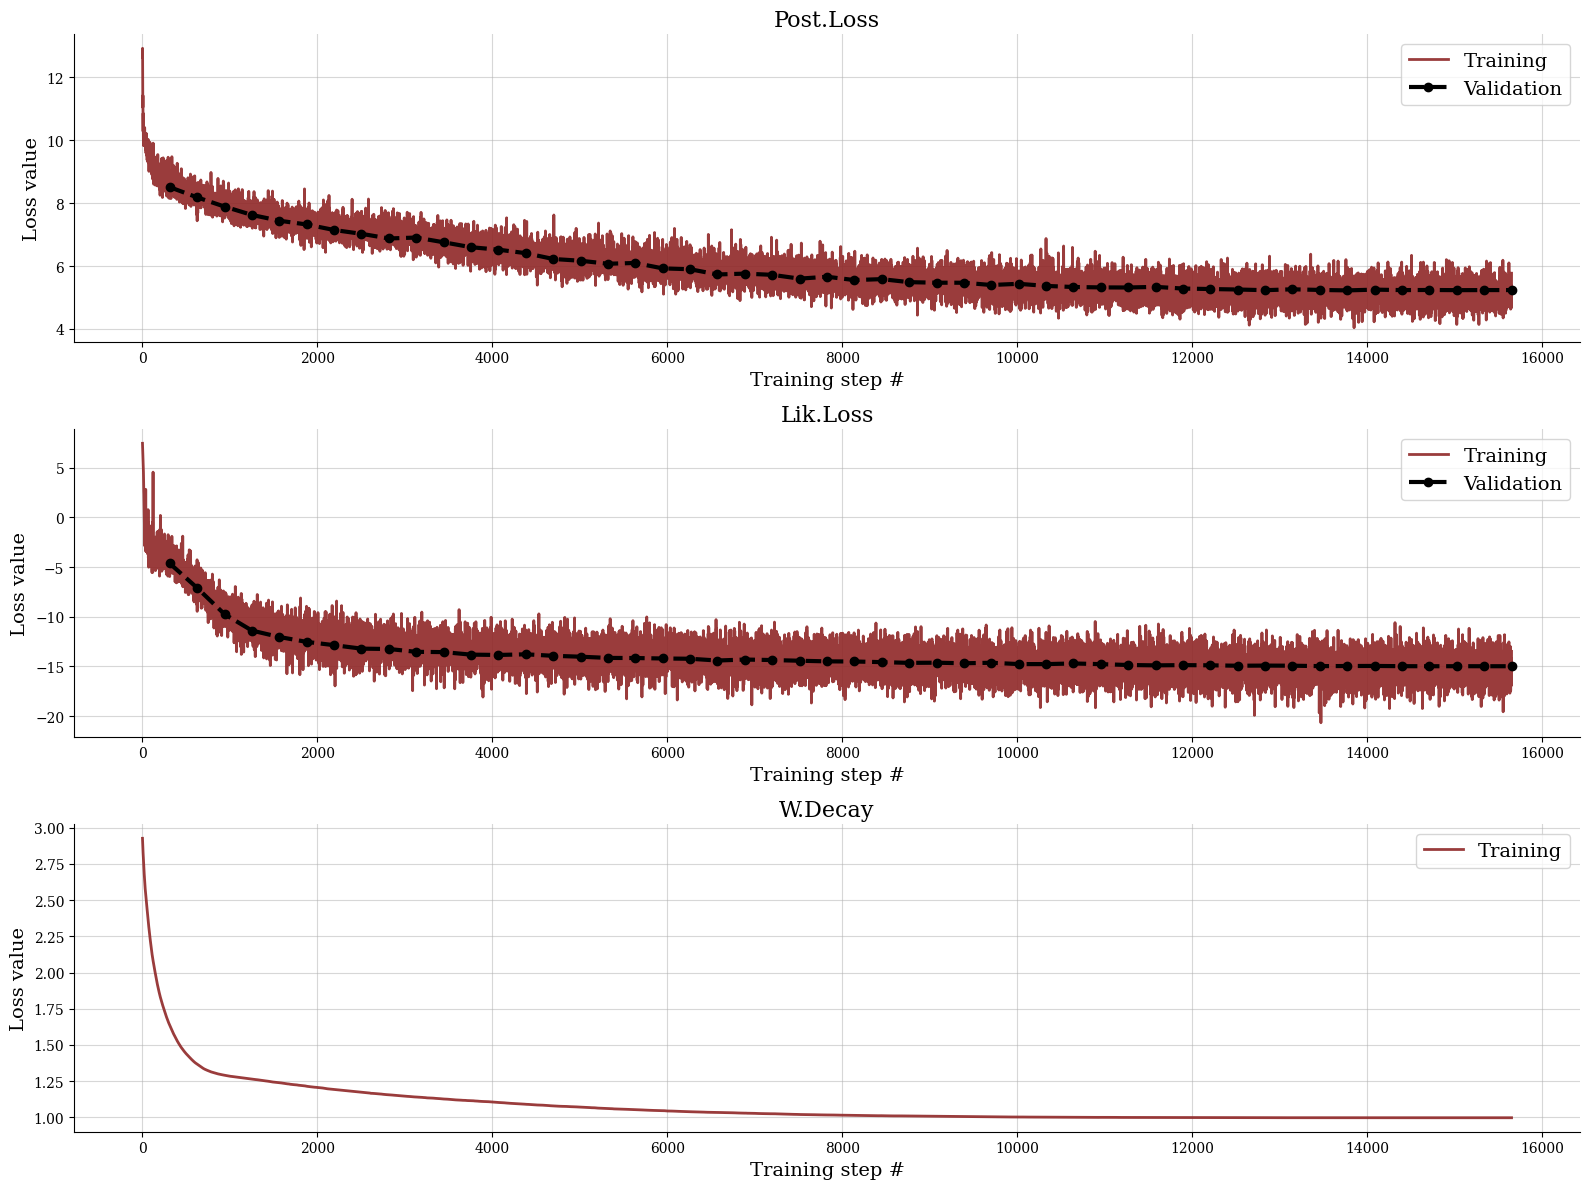

In [16]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

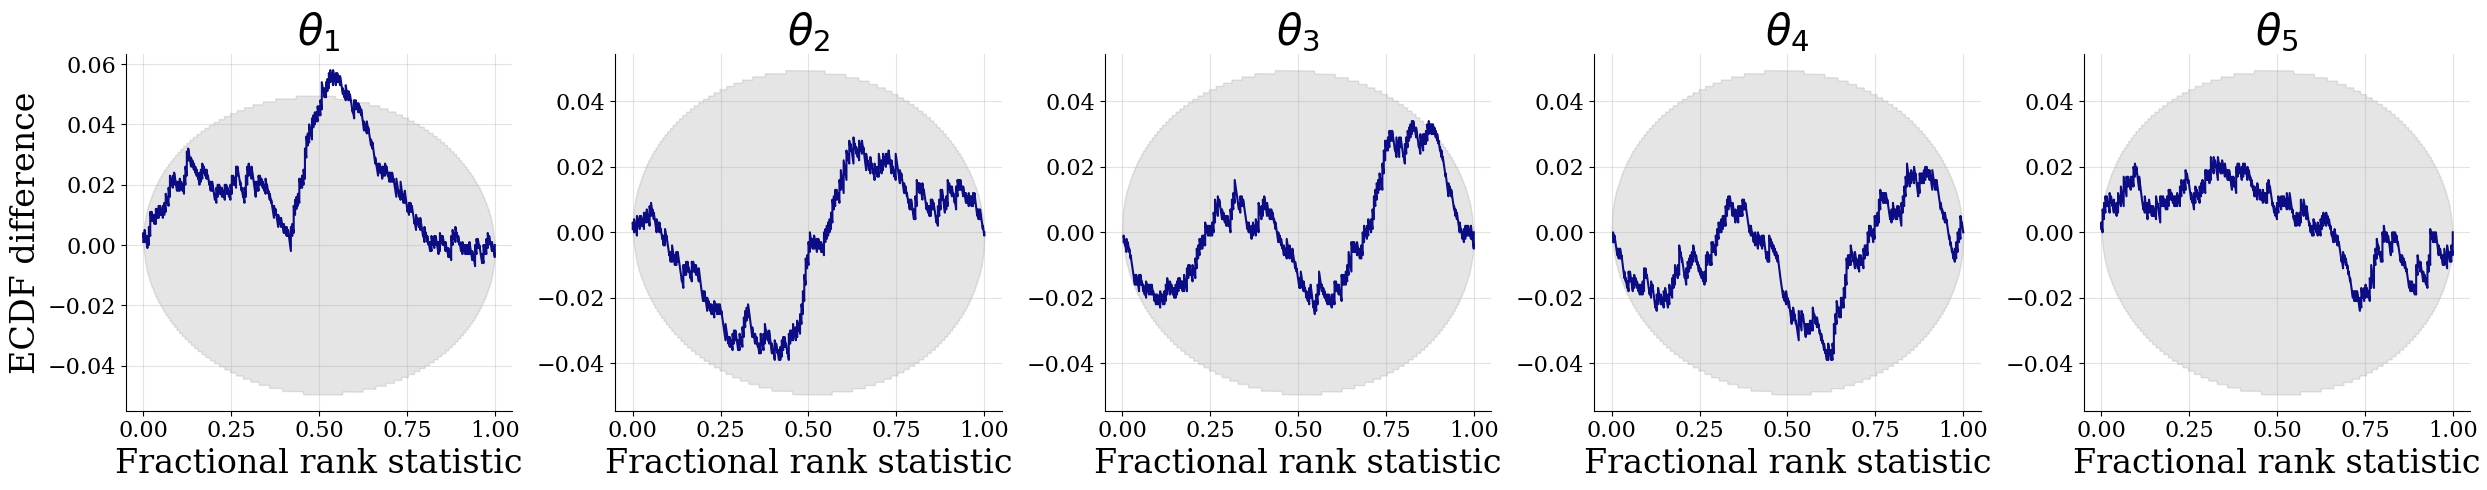

In [17]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

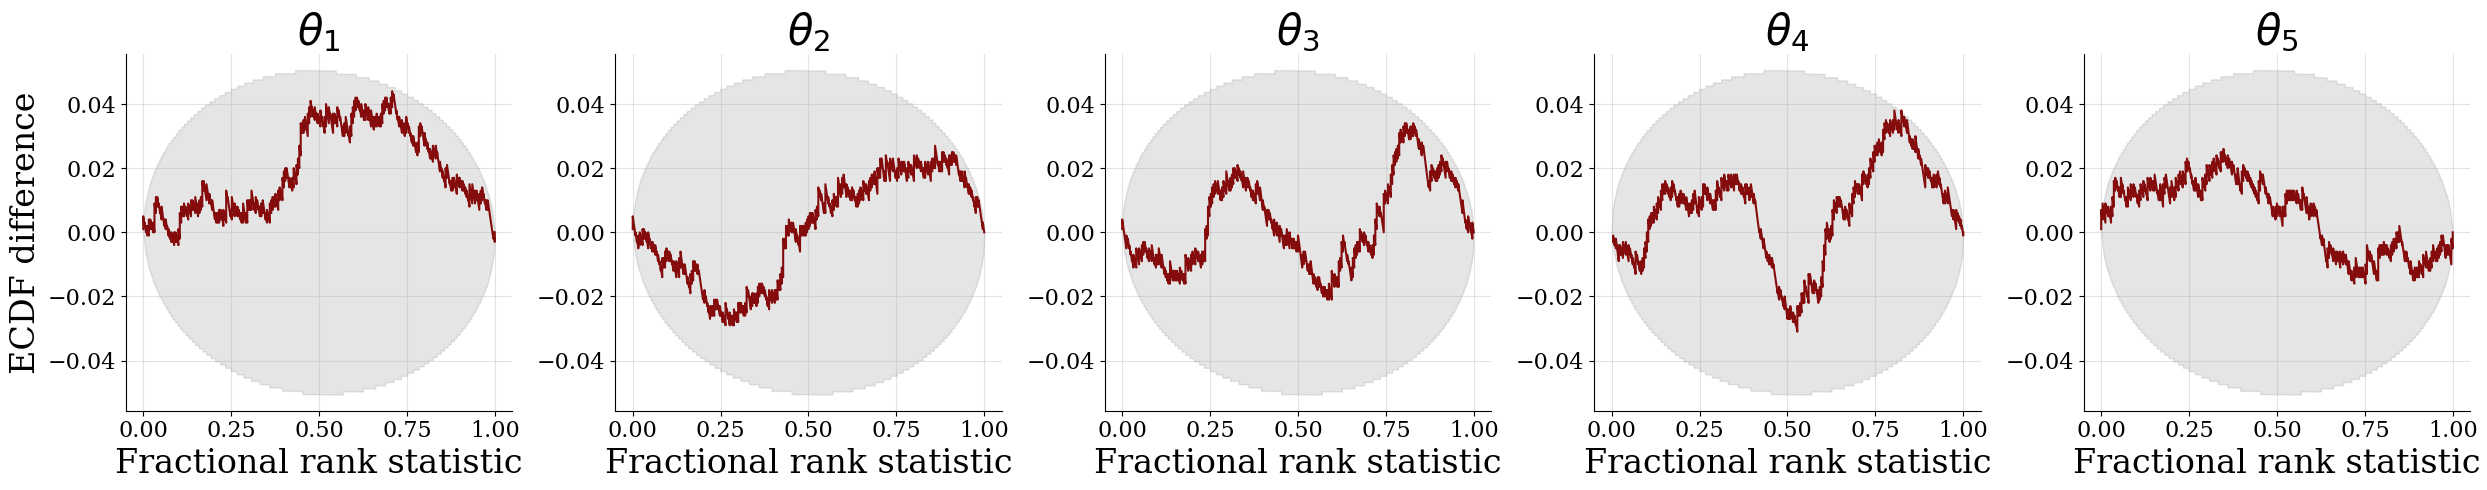

In [18]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")